# Universidad de Buenos Aires
# ViT - TP 1
# Alumno: Matias Werbin

## Vision Transformer (ViT)

El **Vision Transformer (ViT)** es un modelo innovador para la clasificación de imágenes que transforma las imágenes en secuencias de parches más pequeños, comúnmente de $16 \times 16$ píxeles, como se describe en el paper de [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy)  "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Cada parche se considera como una "palabra" o "token" y se proyecta en un espacio de características. Mediante la incorporación de cifrados de posición y un token de clasificación, podemos aplicar un Transformer de manera convencional a esta secuencia, permitiendo su entrenamiento para tareas de clasificación de imágenes.

## Embeddings y Cifrado de Posición

### Embeddings
En el contexto de ViTs, las imágenes son primero divididas en pequeños bloques o patches (como si se cortaran en pequeños cuadrados). Estos patches se tratan como si fueran palabras en un modelo de lenguaje, y a cada uno se le asigna un embedding. Un embedding es simplemente una representación numérica del patch en un espacio de alta dimensión que captura características relevantes del mismo.

Por ejemplo, si divides una imagen de 224x224 píxeles en 16x16 bloques, tendrás 196 patches en total. Cada uno de esos patches se convierte en un vector de embedding, que luego se alimenta al modelo Transformer.

### Positional Embedding (Cifrado Posicional):

El **embedding posicional** agrega información sobre la ubicación de cada parche en la imagen original. En el paper de Alexey Dosovitskiy et al., se evaluaron varias formas de codificar la información espacial con embebidos posicionales. Se observó que, aunque el uso de embebidos mejora el rendimiento en comparación con no usarlos, no hay diferencias significativas entre los métodos probados. Se concluyó que, dado que el modelo opera a nivel de parches en lugar de píxeles, la forma específica de codificar la posición es menos relevante.
## Proceso de Creación de Embeddings

1. **División en Parches**: La imagen se divide en parches de $N \times N$ píxeles.
   
2. **Generación de Embeddings**: Cada parche se transforma en un embedding que captura su información relevante.

3. **Cifrado de Posición**: Se añade un vector de cifrado de posición a cada embedding. 

   Algunos ejemplos del cifrado:


   *  **Codificación Sinusoidal:** La fórmula sinusoidal para embebidos posicionales (tradicional en Transformers-NLP) genera los valores de los embebidos en función de senos y cosenos. Estos valores dependen directamente de la posición y siguen una periodicidad específica para capturar relaciones posicionales. Es determinista y no se ajusta durante el entrenamiento, ya que los valores están calculados y fijos para cada posición.
   Donde:
       - $pos$ es la posición en la secuencia.
       - $i$ es el índice de la dimensión.
       - $d_{model}$ es la dimensión del modelo.

   $$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

   $$PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$



   * **Embebido Posicional Aprendido (a ser implementada por el alumno):** los embebidos posicionales se definen como un parámetro de la red neuronal (usando [nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)), lo que significa que los valores para el embebido  posicional se aprenden durante el proceso de entrenamiento. Se define embedding, matriz de tamaño (1, num_patches, embed_dim), donde num_patches es el número de parches (posiciones) en la secuencia de la imagen y  embed_dim es la dimensión de los embebidos. La inicialización torch.randn genera valores aleatorios para estos embebidos posicionales, y luego el modelo los optimiza durante el entrenamiento, ajustando los valores en función de los gradientes.

4. **Combinación de Embeddings y Cifrado de Posición**: Se suma cada embedding con su correspondiente cifrado de posición, generando un vector final que contiene tanto la información del contenido del parche como su posición en la imagen.

El resultado es una serie de vectores, cada uno representando un parche y su posición, que se alimentan a las capas del Transformer. Esto permite al modelo aprender no solo sobre las características individuales de cada parche, sino también sobre cómo estos se relacionan entre sí en el contexto de la imagen completa.


![Vision Transformer](vit.gif)

*Crédito: [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)*


A continuación, trabajaremos con los **patch embeddings** y la **codificación posicional**, esenciales para que el modelo pueda interpretar las relaciones espaciales en las imágenes. 

## Tareas:

1. **Modificar los parametros:** Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.

2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 


Dispositivo utilizado: cuda


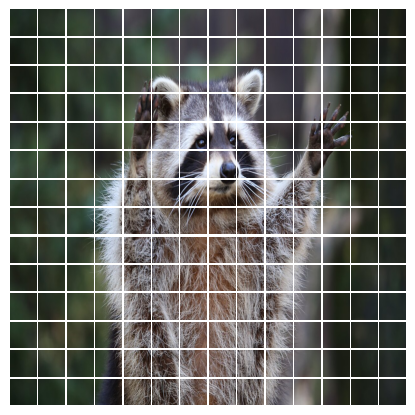

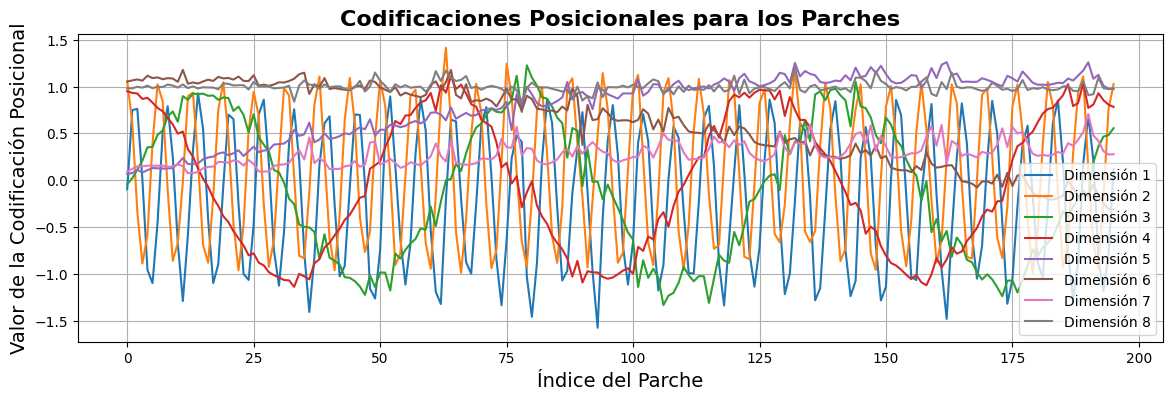

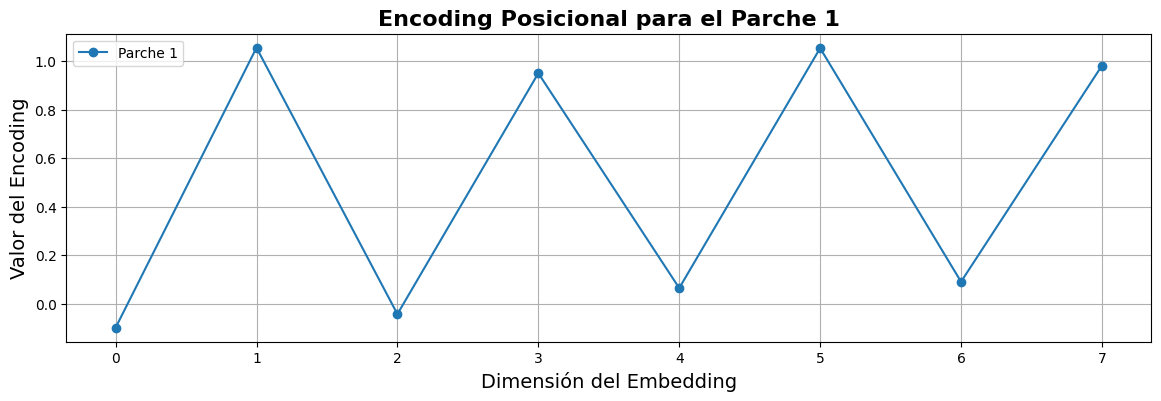

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        print(f'Dispositivo utilizado: {self.device}')
        
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding

class Visualization:
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(f"El índice del parche debe estar entre 0 y {num_patches - 1}, pero se recibió {patch_idx}.")
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensión del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()


# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (img_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)




## Resolución:

### 1. **Modificar los parametros:** Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.


Probando con patch_size=32 y embed_dim=4
Dispositivo utilizado: cuda


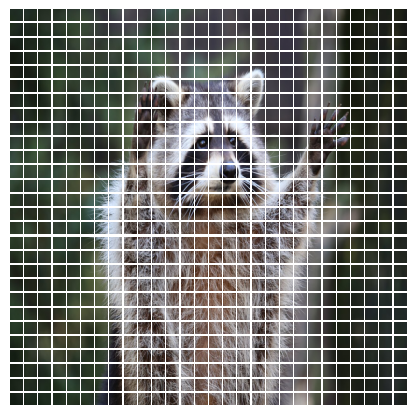

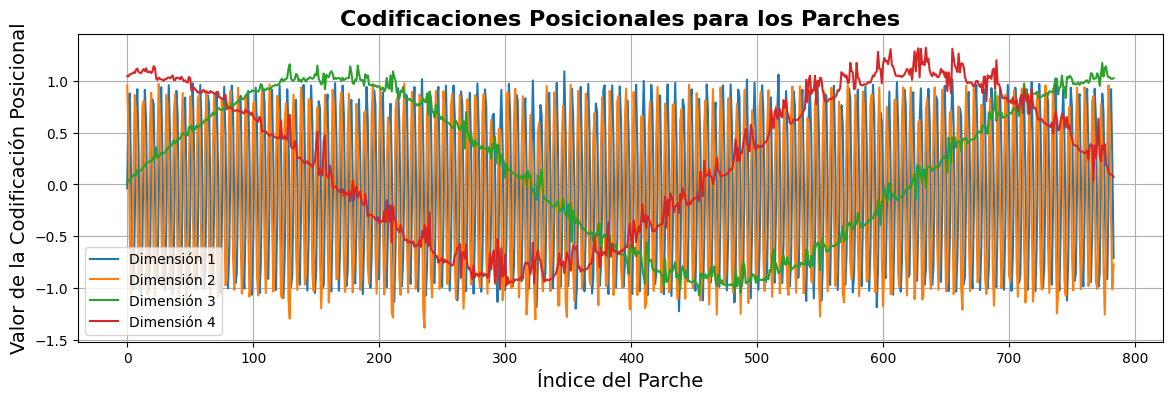

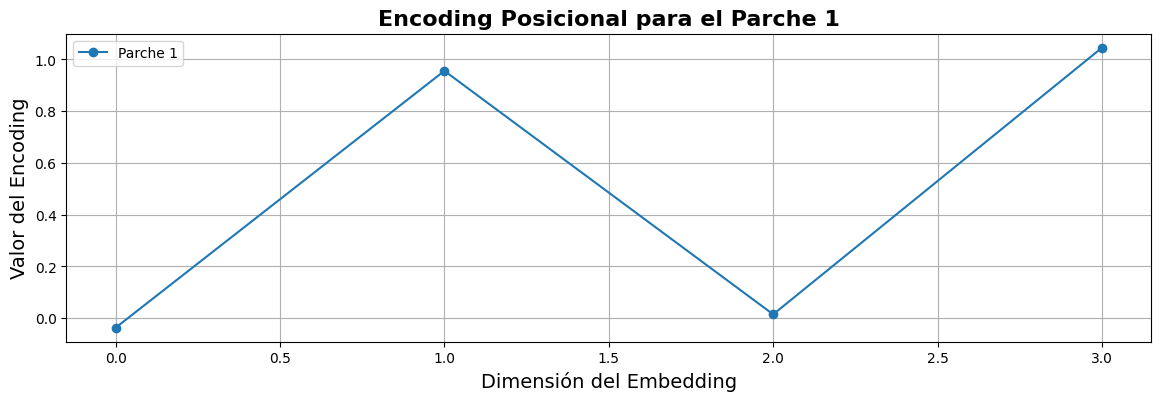


Probando con patch_size=32 y embed_dim=8
Dispositivo utilizado: cuda


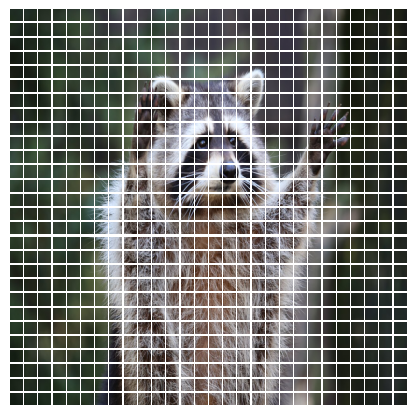

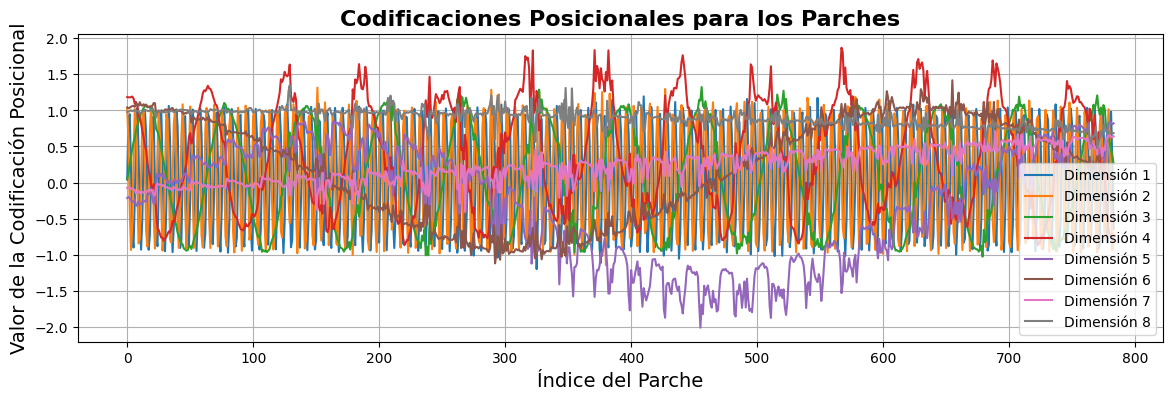

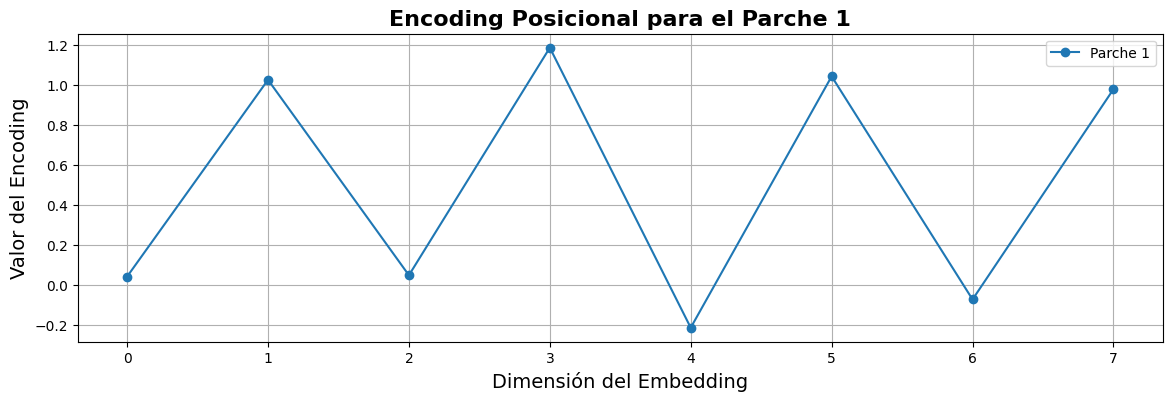


Probando con patch_size=32 y embed_dim=16
Dispositivo utilizado: cuda


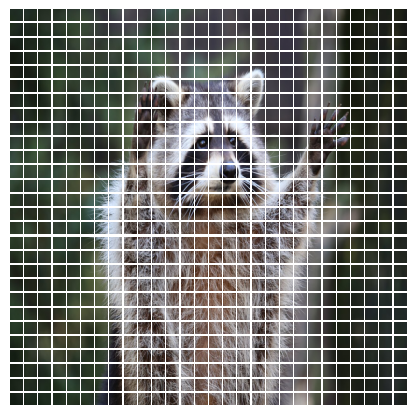

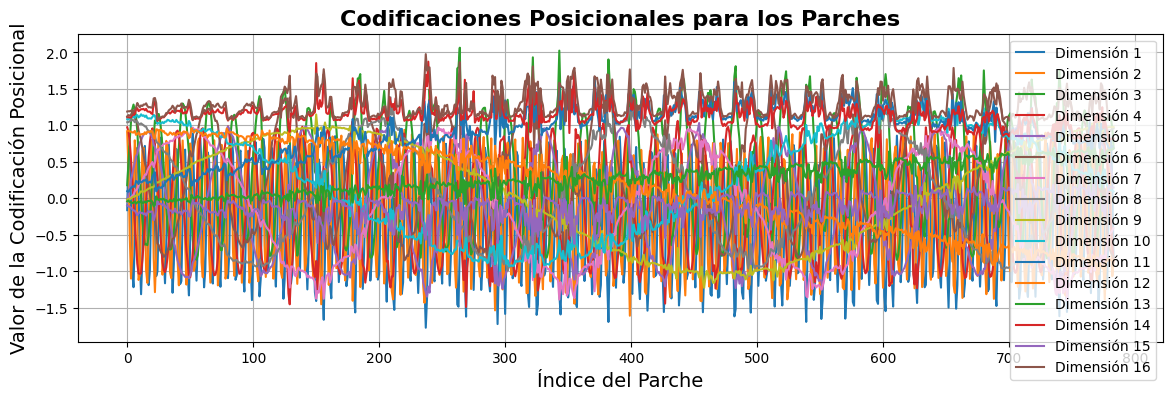

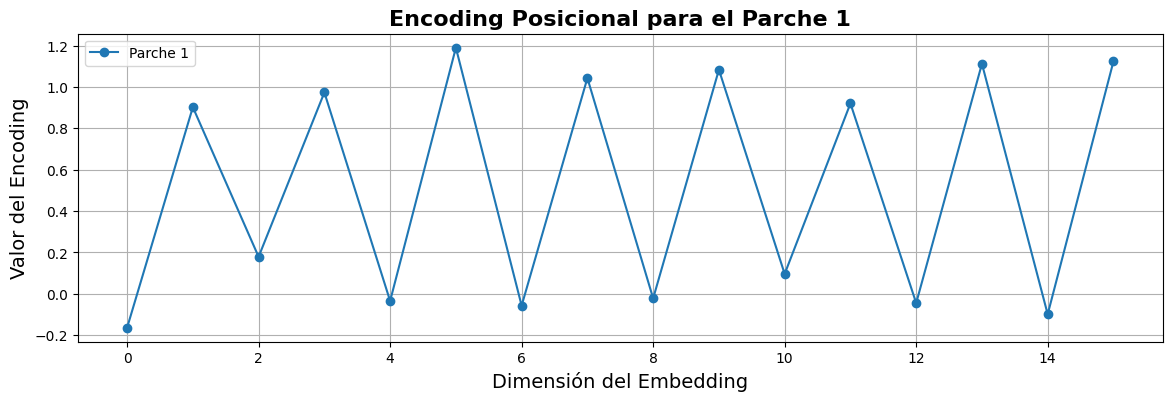


Probando con patch_size=64 y embed_dim=4
Dispositivo utilizado: cuda


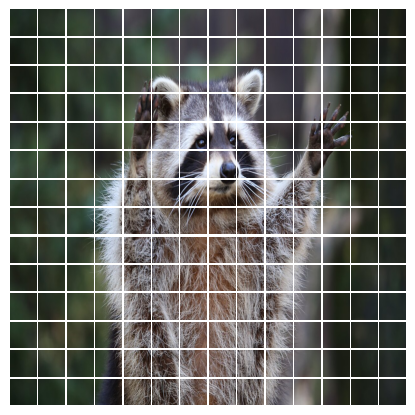

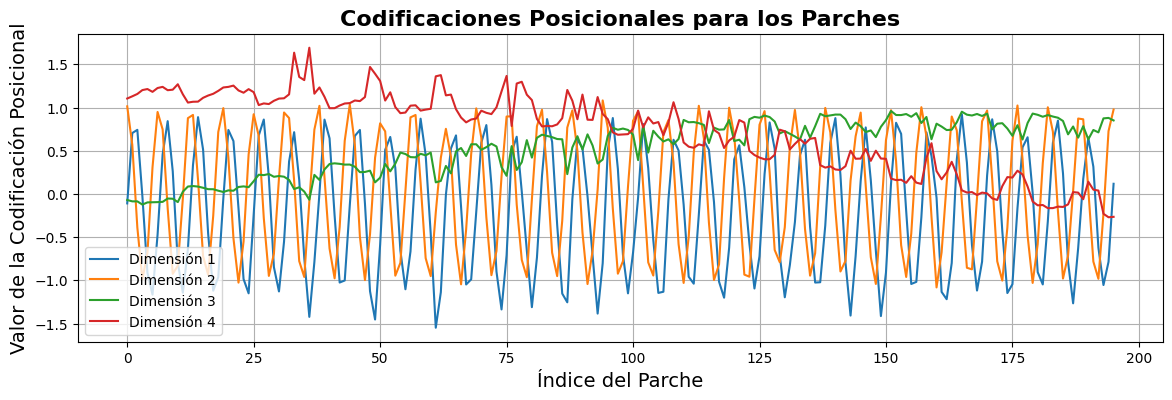

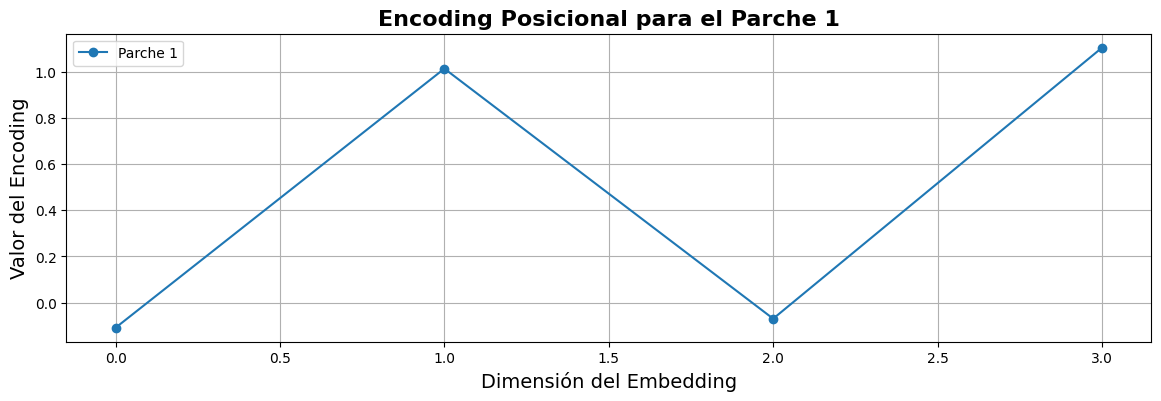


Probando con patch_size=64 y embed_dim=8
Dispositivo utilizado: cuda


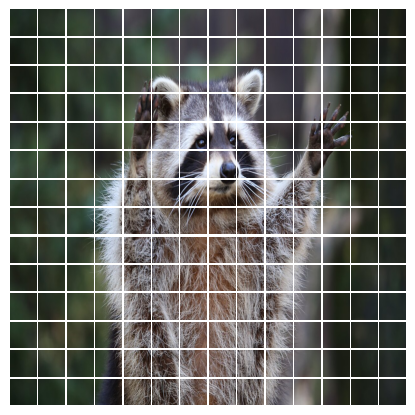

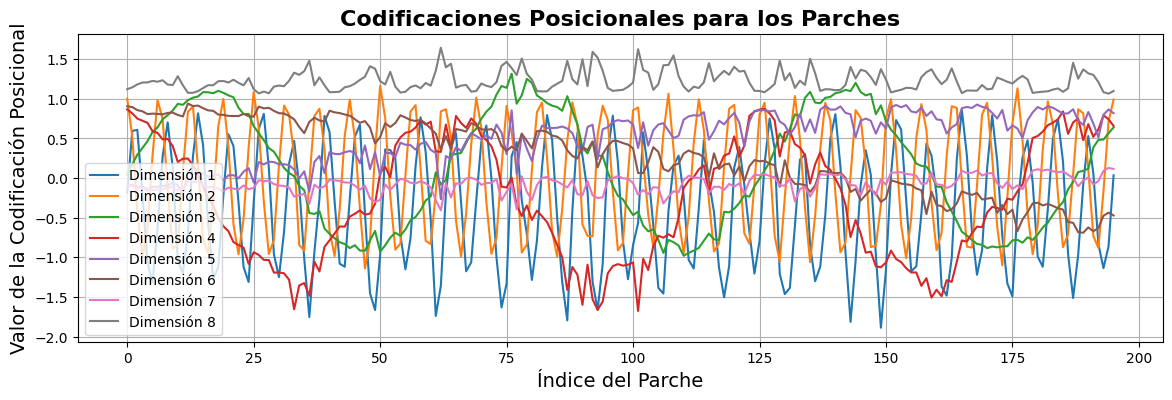

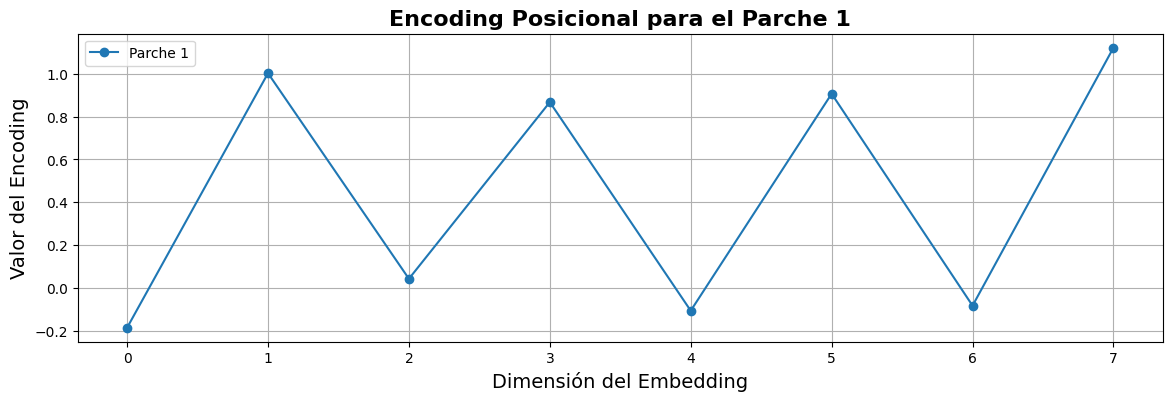


Probando con patch_size=64 y embed_dim=16
Dispositivo utilizado: cuda


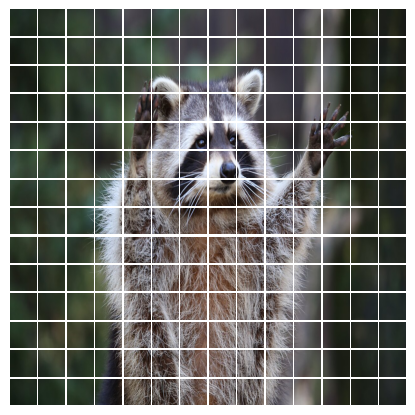

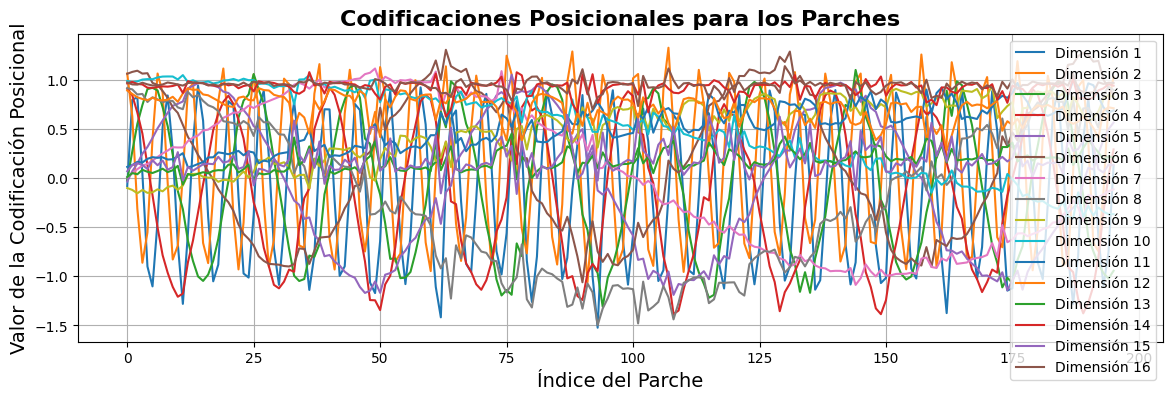

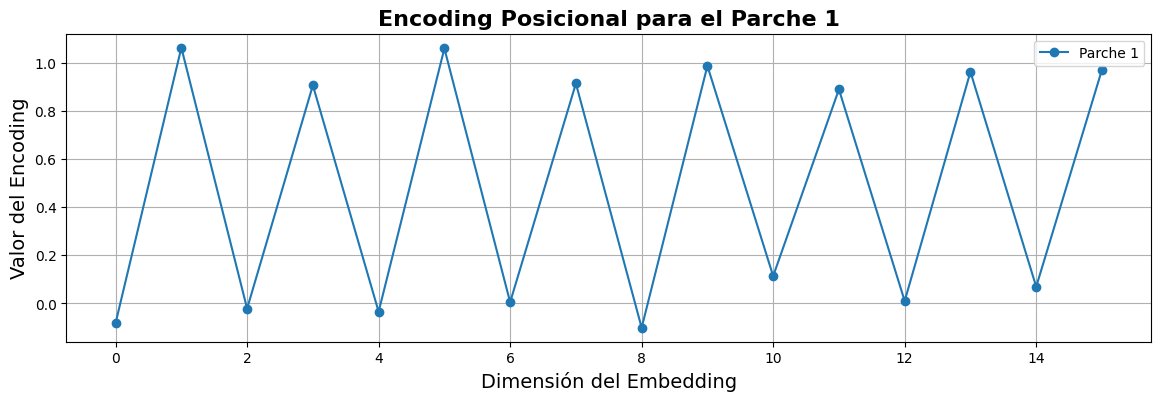


Probando con patch_size=128 y embed_dim=4
Dispositivo utilizado: cuda


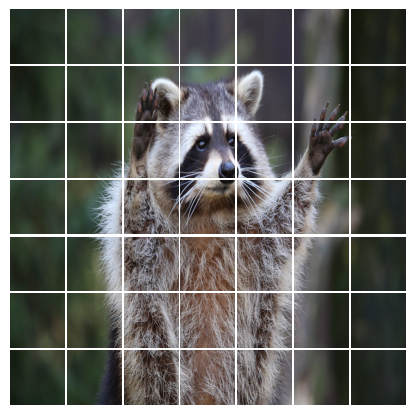

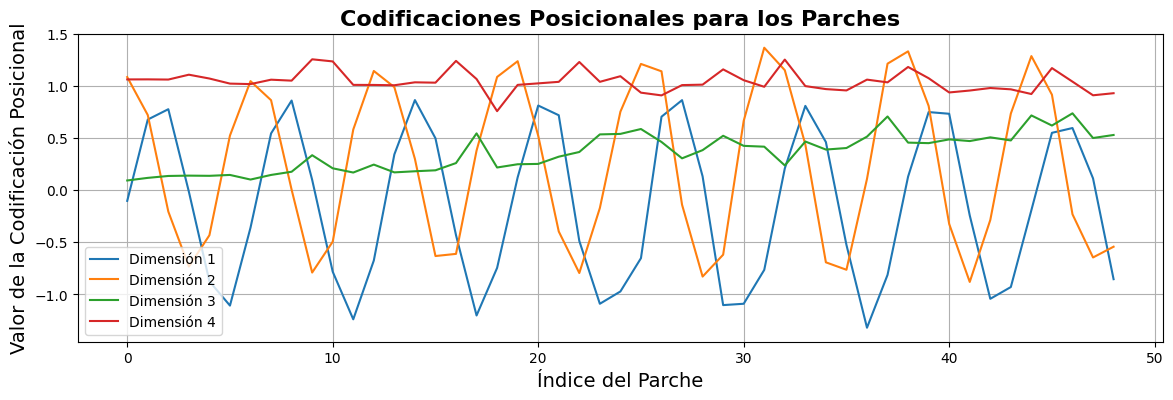

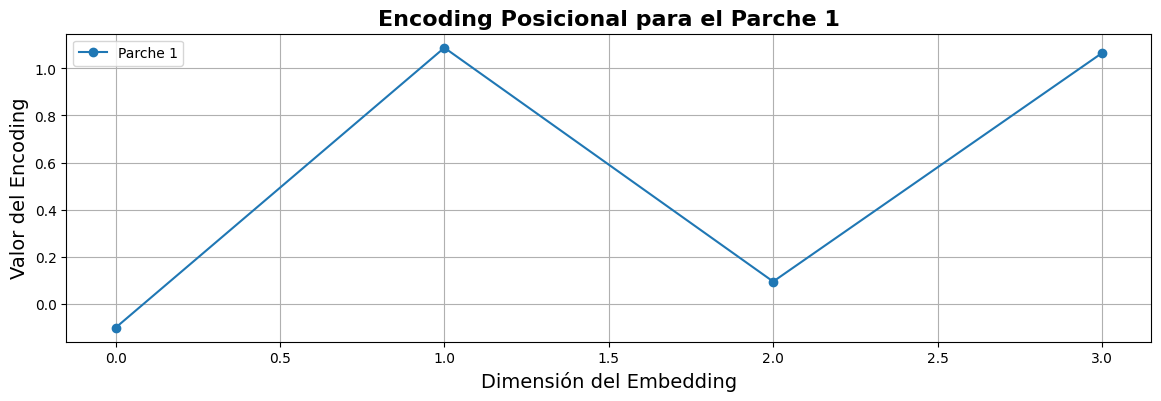


Probando con patch_size=128 y embed_dim=8
Dispositivo utilizado: cuda


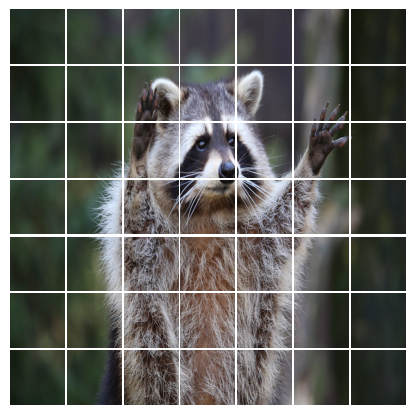

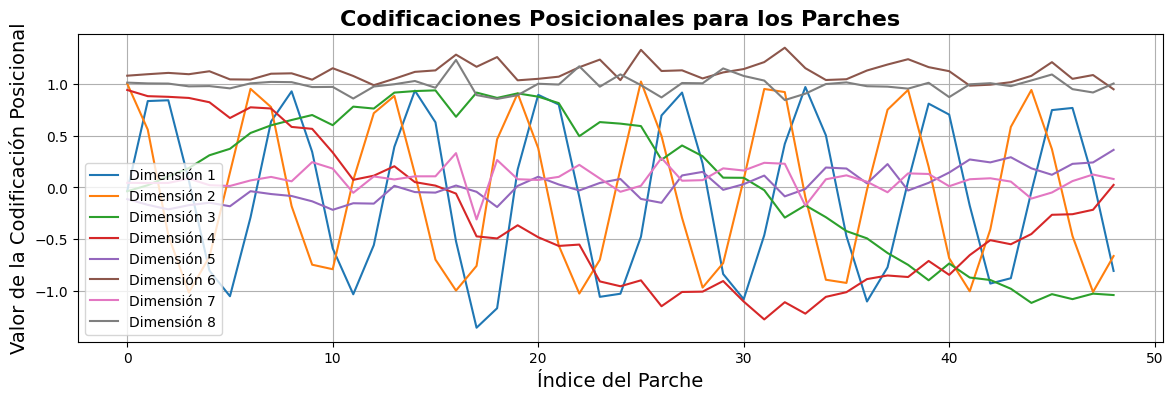

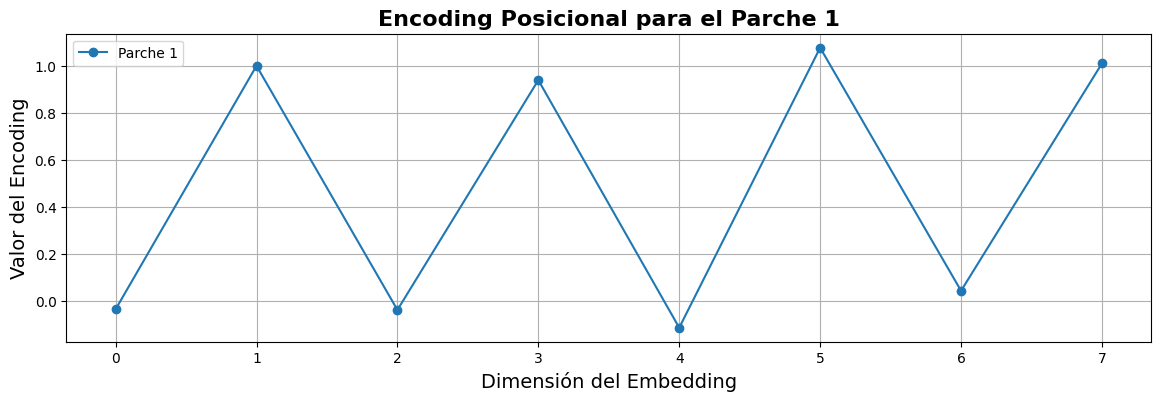


Probando con patch_size=128 y embed_dim=16
Dispositivo utilizado: cuda


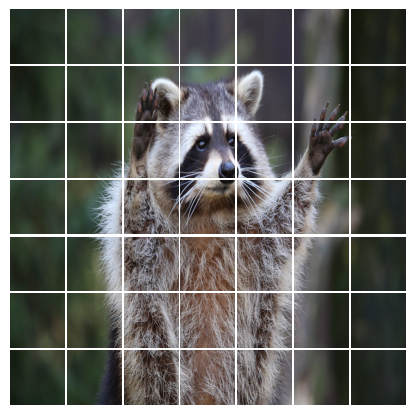

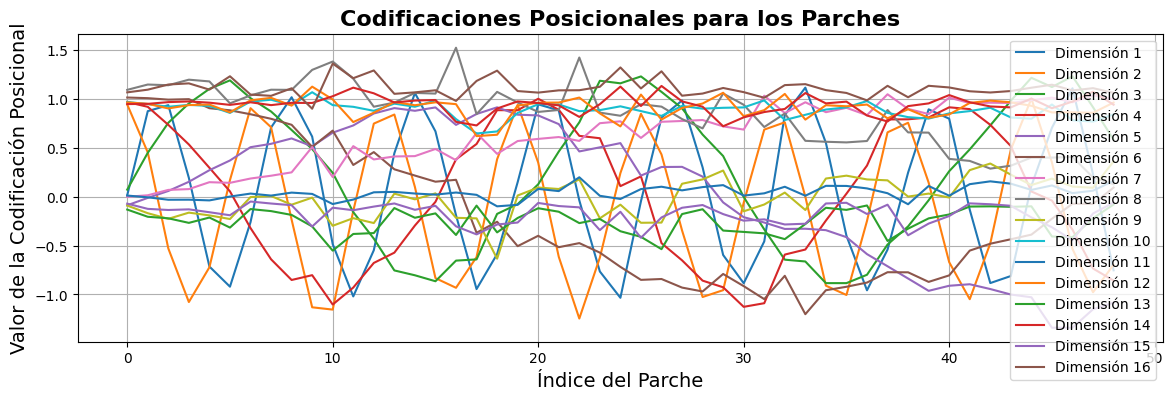

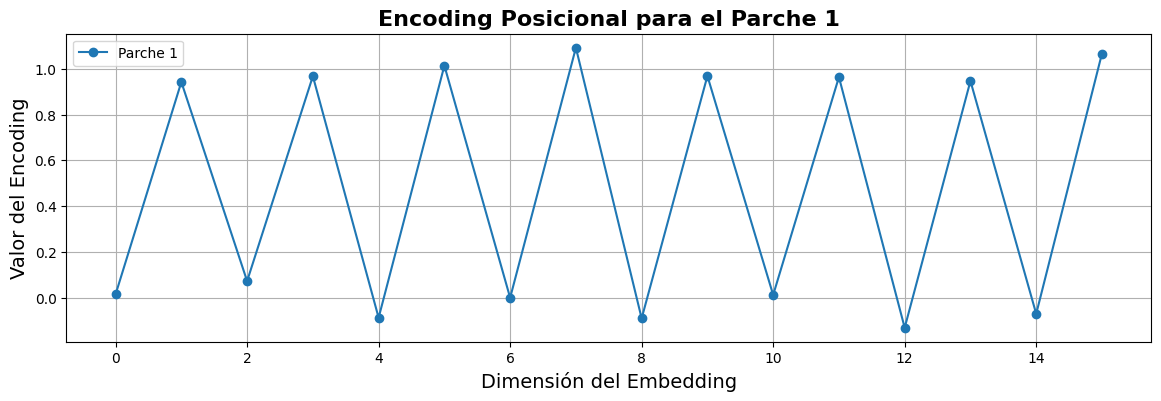

In [2]:
# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_sizes = [32,64,128]
embed_dims = [4,8,16]
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

for patch_size in patch_sizes:
    for embed_dim in embed_dims:
        print(f"\nProbando con patch_size={patch_size} y embed_dim={embed_dim}")
        
        # Preprocesamiento
        config = ConfigPreprocess(img_path, img_size, patch_size)
        
        # Extracción de parches y visualización
        patches = config.extract_patches(config.test_img.squeeze(0))
        Visualization.visualize_patches(patches)
        
        # Generación de embeddings
        embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
        patches = embedded_patches(config.test_img)
        
        # Codificación posicional
        num_patches = (img_size // patch_size) ** 2
        positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
        pos_embeddings = positional_encoding(patches)
        
        # Visualización de codificaciones posicionales
        Visualization.visualize_positional_encoding(pos_embeddings)
        Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

**Número de Parches**

- Ventajas de tener más parches -> parches más pequeños:

    1. Mayor detalle espacial: con más parches, el modelo puede capturar detalles más finos permitiendole una mejor comprensíon de los patrones de la imagen.
    2. Mejor precisión en caracteristicas locales: es más probable que el modelo identifique caracteristicas locales importantes, como bordes, esquinas y texturas dado que los parches más pequeños contienen menos información en caa token, haciendolo más detallado.

- Desventajas de tener más parches:

    1. Mayor complejidad computacional: procesar más parches requiere más recursos computacionales ya que crece también el número de tokens que el modelo debe procesar, lo que puede ralentizar el entrenamiento y la inferencia.
    2. Posible pérdida de contexto global: mayor cantidad de parches pueden fragmentar el contexto global, generando dificultades al modelo de capturar patrones y relaciones de alto nivel en la imagen.
    
- Ventajas de tener más parches -> parches más grandes:
    1. Menor costo computacional: menos parches implican menos tokens a procesar, lo que puede reducir la carga computacional y acelerar el entrenamiento y la inferencia.
    2. Mejor precisión en caracterisiticas globales: al tener menos parches, cada token representa una parte más grande de la imagen, ayudando al modelo a capturar la estructura general de la imagen.

- Desventajas de tener más parches:
    1. Perdida de datalles: parches más grandes tienden a "mezclar" detalles finos y específicos, disminuyendo la capacidad del modelo para capturar caracteristicas locales.
    

**Dimensión de los embeddings**

La dimensión de cada embedding de parche o token, impacta en el rendimiento del modelo. Esta dimensión controla cuanta información puede representar el vector de embedding para cada parche.

- Ventajas de tener embeddings de mayor dimensión:
    1. Mayor capacidad para capturar información: con más dimensiones, el embedding pueda representar características más complejas en cada parche, permitiendo que el modelo distinga detalles sutiles en la imagen.
    2. Mejor rendimiento en tareas complejas: en tareas que requieren alta precisión o en donde las relaciones entre los parches son complejas, una dimensión más alta puede mejorar el rendimiento (OJO!!! una dimension muy alta puede llevar a problemas de sobreajuste).

- Desventajas de tener embeddings de mayor dimensión:
    1. Aumento del costo computacional: más dimensiones implicand más parametros lo cual eleva la complejidad y tiempo de entrenamiento y de inferencia.
    2. Mayor riesgo de sobreajuste: con más dimensiones, el modelo puede ajustarse demasiado a los datos de entrenamiento, especialmente en datos pequeños o cuando no se usan las técnicas de regularización adecuadas.

- Ventajas de tener embeddings de menor dimensión:
    1. Menor costo computacional: menos dimensiones implican menos parametros, lo que reduce la complejidad y el tiempo de entrenamiento y de inferencia.
    2. Menor riesgo de sobreajuste: con menos dimensiones, el modelo puede ser menos propenso a capturar ruido, favoreciendo la generalización.

- Desventajas de tener embeddings de menor dimensión:
    1. Pérdida de capacidad de representación: con menos dimensiones, los embeddings pueden ser incapacaes de representar adecuadamente la información de cada parche, afectandop la precisión del modelo..
    2. Rendimiento limitado en tareas complejas: en tareas complejas con una alta complejidad de patrones visuales, una menor dimensión de embedding puede limitar la capacidad del modelo para capturar caracteristicas complejas y criticas.


### 2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 

Dispositivo utilizado: cuda


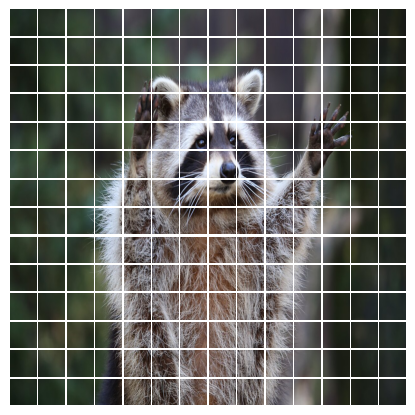

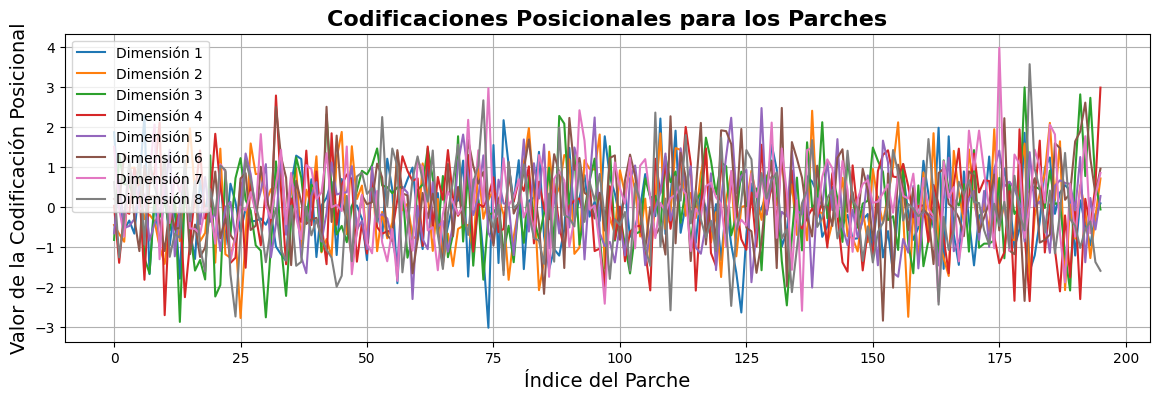

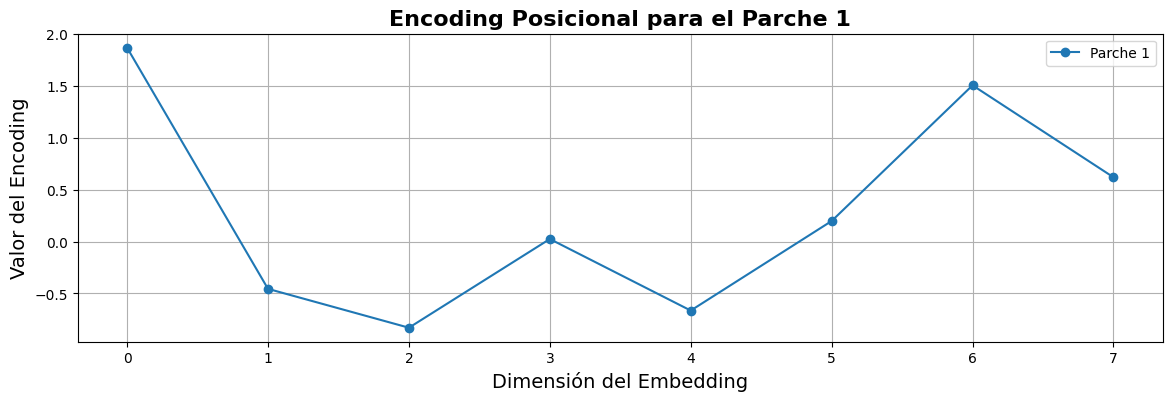

In [3]:
class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super(PositionalEncodingLearned, self).__init__()
        self.positional_embeddings = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
    
        return x + self.positional_embeddings

# Parámetros de entrada
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # Índice del parche para visualizar

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings de parches
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional aprendida
num_patches = (img_size // patch_size) ** 2
positional_encoding_learned = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding_learned(patches)

# Visualización de los embeddings posicionales
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

